### Gillian detrending ###

Applying the detrending approach from Winter et al. (2017) (doi: https://academic.oup.com/climatesystem/article/1/1/dzw006/2912162) to transform the non-stationary daily temperature time series to a stationary daily temperature time series.

In [1]:
# Import local modules
import os
import sys
import glob
import time

# Import third-party modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Set up the parameters
model = "HadGEM3-GC31-MM"
variable = "tas"
season = "ONDJFM" # ideally would be DJF...
period = "Amon"
start_year = "1960"
end_year = "2018"

# Set up the base directory
base_dir = "/gws/nopw/j04/canari/users/benhutch/saved_DePre/"

In [3]:
%%time

# Load the data
arr_file = np.load(
    os.path.join(
        base_dir,
        model,
        variable,
        period,
        season,
        f"{start_year}-{end_year}",
        f"{model}_{variable}_{season}_{period}_{start_year}-{end_year}.npy"
    )
)

CPU times: user 134 μs, sys: 1min 38s, total: 1min 38s
Wall time: 1min 41s


In [4]:
# Load the latitudes and longitudes
lats = np.load(
    os.path.join(
        base_dir,
        model,
        variable,
        period,
        season,
        f"{start_year}-{end_year}",
        f"{model}_{variable}_{season}_{period}_{start_year}-{end_year}_lats.npy"
    )
)

lons = np.load(
    os.path.join(
        base_dir,
        model,
        variable,
        period,
        season,
        f"{start_year}-{end_year}",
        f"{model}_{variable}_{season}_{period}_{start_year}-{end_year}_lons.npy"
    )
)

# load the years
years = np.load(
    os.path.join(
        base_dir,
        model,
        variable,
        period,
        season,
        f"{start_year}-{end_year}",
        f"{model}_{variable}_{season}_{period}_{start_year}-{end_year}_years.npy"
    )
)

# load the members
members = np.load(
    os.path.join(
        base_dir,
        model,
        variable,
        period,
        season,
        f"{start_year}-{end_year}",
        f"{model}_{variable}_{season}_{period}_{start_year}-{end_year}_members.npy"
    )
)

# load the leads
leads = np.load(
    os.path.join(
        base_dir,
        model,
        variable,
        period,
        season,
        f"{start_year}-{end_year}",
        f"{model}_{variable}_{season}_{period}_{start_year}-{end_year}_leads.npy"
    )
)

In [5]:
# print the leads
# Subset the array to the first DJF
# find the indices of leads [2, 3, 4]
desired_leads_DJF = [2, 3, 4]

# find the indices of these
indices = np.where(np.isin(leads, desired_leads_DJF))


In [6]:
indices

(array([1, 2, 3]),)

In [7]:
# subset the array
arr_DJF = arr_file[:, :, indices[0], :, :]

In [8]:
arr_DJF.shape

(59, 10, 3, 324, 432)

In [9]:
# take the mean over the leads
arr_DJF_mean = np.mean(arr_DJF, axis=2)

In [10]:
arr_DJF_mean.shape

(59, 10, 324, 432)

First, for each ensemble member, calculate the global mean temperature anomalies with respect to the final year of data (in this case 2018).

$g_t = \widetilde{g}_t - \widetilde{g}_{2018}$

Where $\widetilde{g}_t$ is the global mean temperature. 

$\widetilde{g}_t$ and $g_{t}$ will vary over different ensemble members 

In [11]:
# calculate the global mean temperature for the final year
# over all ensemble members
global_mean_2018 = np.mean(arr_DJF_mean[-1, :, :, :], axis=(0, 1))

# calculate the temperature anoms
arr_DJF_mean_anoms = arr_DJF_mean - global_mean_2018

In [12]:
arr_DJF_mean_anoms.shape

(59, 10, 324, 432)

Now we want to calculate the locationh and scale paramters for the time series representative of climate in a specific year, in this case the DJF anomalies for 2018.

Hold fire on this until Gillian gets back w/method.

First try regressing out GMST and then detrending the residuals in the same way as Hawkins et al. (2020) (doi: https://doi.org/10.1029/2019GL086259).

Assuming:

$L(t) = \alpha G(t) + \beta$

Where:

* $L(t)$ is the local change in temperature over time
* $G(t)$ is a smoothed version of the GMST change over the same period
* $\alpha$ defines the linear scaling between L and G
* $\beta$ is a constant

Where the residuals are defined as:

$L - \alpha G$

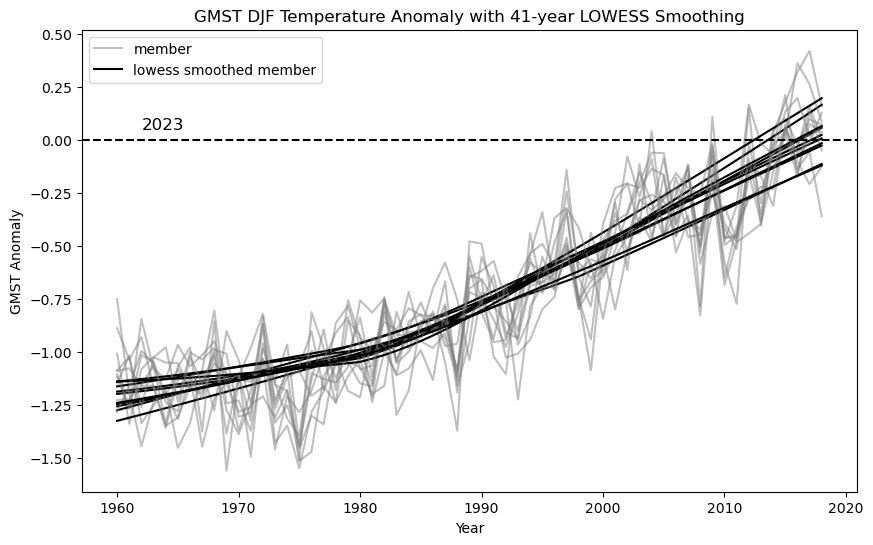

In [24]:
from statsmodels.nonparametric.smoothers_lowess import lowess

# set up the figure size
plt.figure(figsize=(10, 6))

# Assuming arr_DJF_mean_anoms and years are already defined
# First, calculate and plot the GMST DJF temperature anomaly for each ensemble member
# loop over the ensemble members
for i in range(arr_DJF_mean_anoms.shape[1]):
    # Quantify the gmst time series
    gmst = np.mean(arr_DJF_mean_anoms[:, i, :, :], axis=(1, 2))

    # Apply the 41-year LOWESS filter
    smoothed_gmst = lowess(gmst, years, frac=41/len(years), return_sorted=False)

    if i == 0:
        # Plot the GMST time series
        plt.plot(years, gmst, label=f"member", color="gray", alpha=0.5)
        plt.plot(years, smoothed_gmst, label=f"lowess smoothed member", color="black")
    else:
        # Plot the GMST time series
        plt.plot(years, gmst, color="gray", alpha=0.5)
        plt.plot(years, smoothed_gmst, color="black")

# include a horixontal dashed line with a lable for 0 degrees in 2023
plt.axhline(0, color="black", linestyle="--")

# add text to the plot
plt.text(1962, 0.05, "2023", color="black", fontsize=12, ha="left")

plt.xlabel('Year')
plt.ylabel('GMST Anomaly')
plt.title('GMST DJF Temperature Anomaly with 41-year LOWESS Smoothing')
plt.legend()
plt.show()

In [26]:
# Fit 10 linear regressions
# between the smoothed GMST time series and the local change over the UK
# define the UK by clark et al 2017
uk_grid = {
    'lon1': -10,
    'lon2': 3,
    'lat1': 50,
    'lat2': 60
}

# find the indices of the UK lats and lons
lon1, lon2 = np.where((lons >= uk_grid['lon1']) & (lons <= uk_grid['lon2']))[0][[0, -1]]
lat1, lat2 = np.where((lats >= uk_grid['lat1']) & (lats <= uk_grid['lat2']))[0][[0, -1]]

# subset the array
arr_DJF_mean_uk = arr_DJF_mean[:, :, lat1:lat2+1, lon1:lon2+1]

# calculate the mean over the UK
arr_DJF_mean_uk = np.mean(arr_DJF_mean_uk, axis=(2, 3))

In [27]:
arr_DJF_mean_uk.shape

(59, 10)

In [29]:
# Set up a dataframe to process the data
# loop over the ensemble members
df = pd.DataFrame()

for i in range(arr_DJF_mean_uk.shape[1]):
    # set up a new df
    df_this = pd.DataFrame({
        "year": years,
        "member": i + 1,
        "smoothed_gmst": smoothed_gmst,
        "uk": arr_DJF_mean_uk[:, i]
    })

    # concat this with the new df
    df = pd.concat([df, df_this])

In [32]:
df.shape

(590, 4)